In [1]:
import pandas as pd
df=pd.read_csv("U.S. COVID-19 Deaths.csv")
df.head()

,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
0,3/3/2020,US,United States of America,AMRO,44,112,2,2
1,3/4/2020,US,United States of America,AMRO,21,133,3,5
2,3/5/2020,US,United States of America,AMRO,19,152,5,10
3,3/6/2020,US,United States of America,AMRO,65,217,1,11
4,3/7/2020,US,United States of America,AMRO,0,217,0,11


In [2]:
df.tail()

,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
199,9/18/2020,US,United States of America,AMRO,40795,6571119,1204,195638
200,9/19/2020,US,United States of America,AMRO,42618,6613737,827,196465
201,9/20/2020,US,United States of America,AMRO,48266,6662003,977,197442
202,9/21/2020,US,United States of America,AMRO,41695,6703698,652,198094
203,9/22/2020,US,United States of America,AMRO,36766,6740464,269,198363


### I. Projection of cumulative deaths

In [3]:
df=df[["Date_reported"," Cumulative_deaths"]]
df.tail()

,Date_reported,Cumulative_deaths
199,9/18/2020,195638
200,9/19/2020,196465
201,9/20/2020,197442
202,9/21/2020,198094
203,9/22/2020,198363


In [4]:
from matplotlib import pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import math

In [5]:
X = df[[" Cumulative_deaths"]].values
size = int(len(X) * 0.95)
train, test = X[0:size], X[size:len(X)]

In [6]:
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,2))
	model_fit = model.fit(disp=-1)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
mape = np.mean(np.abs(predictions -test )/np.abs(test))
print('MAPE: '+str(mape))
error = mean_squared_error(test, predictions)
RMSE=math.sqrt(error)
print("RMSE: ", RMSE)

MAPE: 0.0008945782140556889
RMSE:  203.74992206850942


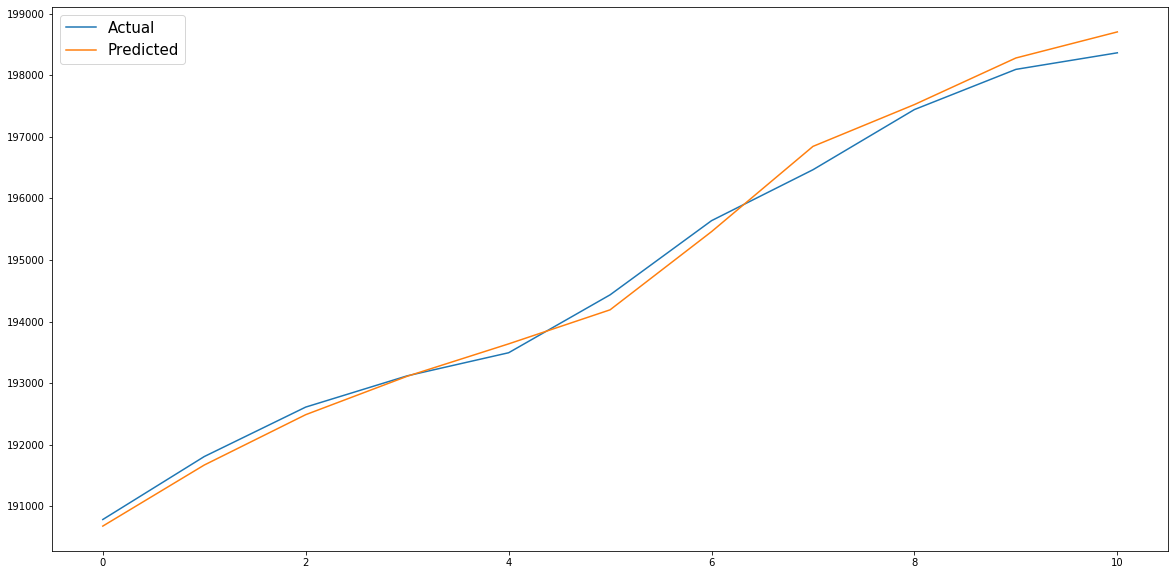

In [15]:
plt.figure(figsize=(20,10))
plt.plot(test,label="Actual")
plt.plot(predictions,label="Predicted")
plt.legend(fontsize=15)
plt.show()

In [7]:
fc, se, conf=model_fit.forecast(len(test)+7,alpha=0.01)

In [8]:
fc=pd.DataFrame(fc).rename(columns={0:"forecast"})
fc.tail(7)

,forecast
11,207135.986454
12,208049.568460
13,208920.877077
14,209716.138897
15,210456.986980
16,211201.869254
17,212004.633699


In [9]:
se=pd.DataFrame(conf).rename(columns={0:"lower bound",1:"upper bound"})
se.tail(7)

,lower bound,upper bound
11,195438.752610,218833.220297
12,195322.404096,220776.732825
13,195098.525029,222743.229125
14,194729.610863,224702.666930
15,194276.572743,226637.401217
16,193850.699222,228553.039286
17,193536.466205,230472.801193


In [11]:
date=df[["Date_reported"]]
train_date, test_date = date[0:size], date[size:len(X)]
test_date.head()

,Date_reported
193,9/12/2020
194,9/13/2020
195,9/14/2020
196,9/15/2020
197,9/16/2020


In [12]:
import datetime
from datetime import timedelta, date

def daterange(date1, date2):
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + timedelta(n)


days=daterange(datetime.datetime(2020, 9,12),
               datetime.datetime(2020, 9, 29))
days=pd.DataFrame(days).rename(columns={0:"Date"})
days.tail(7)

,Date
11,2020-09-23
12,2020-09-24
13,2020-09-25
14,2020-09-26
15,2020-09-27
16,2020-09-28
17,2020-09-29


In [13]:
us_deaths=pd.concat([days,fc,se],axis=1)
us_deaths.tail(7)

,Date,forecast,lower bound,upper bound
11,2020-09-23,207135.986454,195438.752610,218833.220297
12,2020-09-24,208049.568460,195322.404096,220776.732825
13,2020-09-25,208920.877077,195098.525029,222743.229125
14,2020-09-26,209716.138897,194729.610863,224702.666930
15,2020-09-27,210456.986980,194276.572743,226637.401217
16,2020-09-28,211201.869254,193850.699222,228553.039286
17,2020-09-29,212004.633699,193536.466205,230472.801193


In [29]:
difference = us_deaths.diff(axis=0);

print("Difference between rows(Period=1):");

difference=pd.DataFrame(difference).drop(["Date"],axis=1).rename(columns={"forecast":"Daily change"})
difference=pd.concat([days,difference],axis=1)
difference.tail(7)

Difference between rows(Period=1):


,Date,Daily change,lower bound,upper bound
11,2020-09-23,885.993101,-125.002377,1896.988578
12,2020-09-24,913.582007,-116.348514,1943.512527
13,2020-09-25,871.308617,-223.879066,1966.496301
14,2020-09-26,795.261819,-368.914166,1959.437805
15,2020-09-27,740.848083,-453.038121,1934.734286
16,2020-09-28,744.882274,-425.873521,1915.638069
17,2020-09-29,802.764445,-314.233017,1919.761907


The graph shows that the model slightly overestimates, but the overestimation is less than 1,000, even at the widest gap. COVID-19 deaths in the United States will surpass 200,000 tomorrow, 9/23/2020. Moreover, the projected daily changes show that the situation is far from stabilizing. In stabilizing situations, daily changes will decrease everyday. However, as the table above shown, daily changes since 9/18 to 9/22 had not been decreasing. Projected daily changes from 9/23 to 9/29 are not decreasing as well. Hence, the pandemic is far from stabilizing in the U.S. 

### II. Projection of cumulative cases 

In [22]:
df=pd.read_csv("U.S. COVID-19 Deaths.csv")
df=df[["Date_reported"," Cumulative_cases"]]
df.tail()

,Date_reported,Cumulative_cases
199,9/18/2020,6571119
200,9/19/2020,6613737
201,9/20/2020,6662003
202,9/21/2020,6703698
203,9/22/2020,6740464


In [23]:
X = df[[" Cumulative_cases"]].values
size = int(len(X) * 0.95)
train, test = X[0:size], X[size:len(X)]

In [28]:
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(5,2,1))
	model_fit = model.fit(disp=-1)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
mape = np.mean(np.abs(predictions -test )/np.abs(test))
print('MAPE: '+str(mape))
error = mean_squared_error(test, predictions)
RMSE=math.sqrt(error)
print("RMSE: ", RMSE)

MAPE: 0.00039203362801459597
RMSE:  3071.570140900326


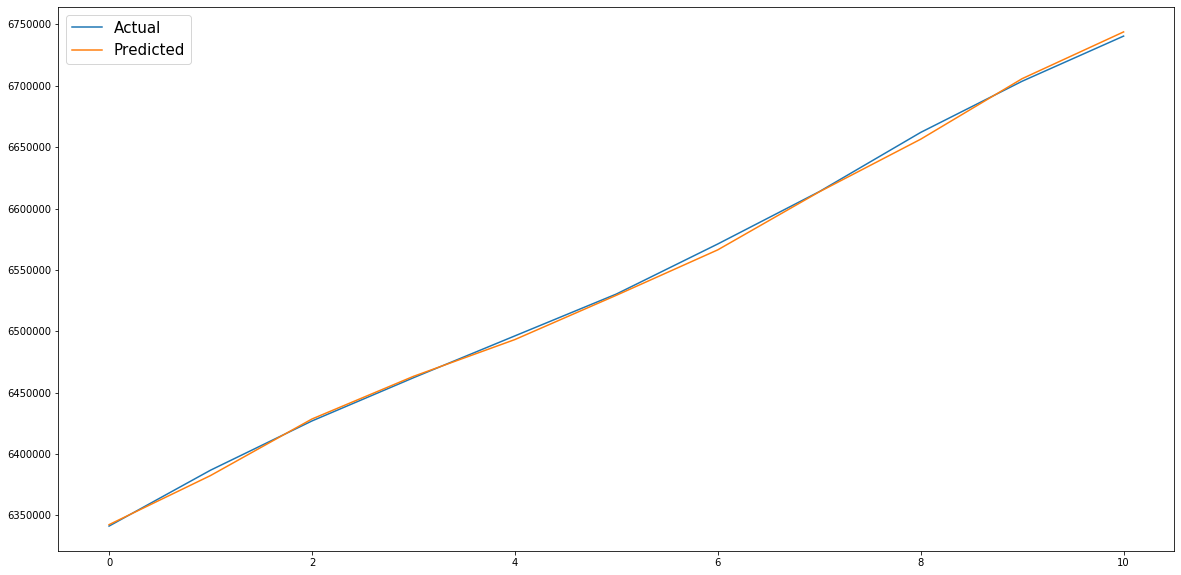

In [37]:
plt.figure(figsize=(20,10))
plt.plot(test,label="Actual")
plt.plot(predictions,label="Predicted")
plt.legend(fontsize=15)
plt.show()

In [30]:
fc, se, conf=model_fit.forecast(len(test)+7,alpha=0.01)

In [31]:
fc=pd.DataFrame(fc).rename(columns={0:"forecast"})
fc.tail(7)

,forecast
11,7.207569e+06
12,7.252129e+06
13,7.296386e+06
14,7.340256e+06
15,7.384030e+06
16,7.428197e+06
17,7.472949e+06


In [32]:
se=pd.DataFrame(conf).rename(columns={0:"lower bound",1:"upper bound"})
se.tail(7)

,lower bound,upper bound
11,7.060262e+06,7.354875e+06
12,7.089950e+06,7.414308e+06
13,7.118760e+06,7.474013e+06
14,7.146340e+06,7.534172e+06
15,7.173029e+06,7.595032e+06
16,7.199558e+06,7.656836e+06
17,7.226373e+06,7.719525e+06


In [33]:
date=df[["Date_reported"]]
train_date, test_date = date[0:size], date[size:len(X)]
test_date.head()

,Date_reported
193,9/12/2020
194,9/13/2020
195,9/14/2020
196,9/15/2020
197,9/16/2020


In [34]:
import datetime
from datetime import timedelta, date

def daterange(date1, date2):
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + timedelta(n)


days=daterange(datetime.datetime(2020, 9,12),
               datetime.datetime(2020, 9, 29))
days=pd.DataFrame(days).rename(columns={0:"Date"})
days.tail(7)

,Date
11,2020-09-23
12,2020-09-24
13,2020-09-25
14,2020-09-26
15,2020-09-27
16,2020-09-28
17,2020-09-29


In [35]:
us_cases=pd.concat([days,fc,se],axis=1)
us_cases.tail(7)

,Date,forecast,lower bound,upper bound
11,2020-09-23,7.207569e+06,7.060262e+06,7.354875e+06
12,2020-09-24,7.252129e+06,7.089950e+06,7.414308e+06
13,2020-09-25,7.296386e+06,7.118760e+06,7.474013e+06
14,2020-09-26,7.340256e+06,7.146340e+06,7.534172e+06
15,2020-09-27,7.384030e+06,7.173029e+06,7.595032e+06
16,2020-09-28,7.428197e+06,7.199558e+06,7.656836e+06
17,2020-09-29,7.472949e+06,7.226373e+06,7.719525e+06


In [36]:
difference = us_cases.diff(axis=0);

difference=pd.DataFrame(difference).drop(["Date"],axis=1).rename(columns={"forecast":"Daily change"})
difference=pd.concat([days,difference],axis=1)
difference.tail(7)

,Date,Daily change,lower bound,upper bound
11,2020-09-23,44214.817283,29573.574252,58856.060314
12,2020-09-24,44560.765472,29688.551426,59432.979519
13,2020-09-25,44256.958503,28809.609151,59704.307855
14,2020-09-26,43869.810242,27579.950942,60159.669542
15,2020-09-27,43774.201388,26688.796958,60859.605818
16,2020-09-28,44166.315351,26529.045756,61803.584946
17,2020-09-29,44752.234472,26814.727092,62689.741851


Daily cases are not stabilizing either. Both daily changes in new cases and death toll are not stabilizing. The pandemic is far from stabilizing in the United States.